Welcome to my first data analysis project! This will explore health and its correlation to COVID-19 positive case and death rates.

The main question I want to try to answer is: Does one's health and diet (specifically obesity and their proximity to a grocery store vs. a convenience store.

Part one looks at overall statistics for each state. It compares the total number of convenience & grocery stores (circa 2016), and COVID infections / deaths (circa November 2020).

In [2]:
# Import everything

import pandas as pd
import pprint as pp
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import linregress

In [3]:
# Read Confirmed Cases (all American counties)
file_one = "Resources/1_county_level_confirmed_cases.csv"

In [4]:
# Print file_one into a dataframe
file_one_df = pd.read_csv(file_one, encoding="ISO-8859-1")
file_one_df.head()

,last_update,location_type,state,county_name,county_name_long,fips_code,lat,lon,NCHS_urbanization,total_population,confirmed,confirmed_per_100000,deaths,deaths_per_100000
0,2020-10-22 02:24:33 UTC,county,Alabama,Autauga,"Autauga, Alabama, US",1001.0,32.539527,-86.644082,Medium metro,55200.0,2021,3661.23,30,54.35
1,2020-10-22 02:24:33 UTC,county,Alabama,Baldwin,"Baldwin, Alabama, US",1003.0,30.727750,-87.722071,Small metro,208107.0,6443,3096.00,69,33.16
2,2020-10-22 02:24:33 UTC,county,Alabama,Barbour,"Barbour, Alabama, US",1005.0,31.868263,-85.387129,Non-core,25782.0,996,3863.16,9,34.91
3,2020-10-22 02:24:33 UTC,county,Alabama,Bibb,"Bibb, Alabama, US",1007.0,32.996421,-87.125115,Large fringe metro,22527.0,801,3555.73,14,62.15
4,2020-10-22 02:24:33 UTC,county,Alabama,Blount,"Blount, Alabama, US",1009.0,33.982109,-86.567906,Large fringe metro,57645.0,1873,3249.20,25,43.37


In [5]:
# Manipulate file_one to show only specific columns (columns like "location_type aren't needed for analysis")
clean_file_one_df = pd.DataFrame(file_one_df, columns= ['state','county_name','total_population','confirmed', 'deaths'])
clean_file_one_df.head()

,state,county_name,total_population,confirmed,deaths
0,Alabama,Autauga,55200.0,2021,30
1,Alabama,Baldwin,208107.0,6443,69
2,Alabama,Barbour,25782.0,996,9
3,Alabama,Bibb,22527.0,801,14
4,Alabama,Blount,57645.0,1873,25


In [6]:
# To merge with other dataframes, a new, open row was needed to equal the other dataframes.

new_row = pd.DataFrame({'state':'', 'county_name':'', 'total_population':'', 
                        'confirmed':'', 'deaths':''}, index =[0])
new_row_df = pd.concat([new_row, clean_file_one_df[:]]).reset_index(drop = True) 
new_row_df.head()

,state,county_name,total_population,confirmed,deaths
0,,,,,
1,Alabama,Autauga,55200,2021,30
2,Alabama,Baldwin,208107,6443,69
3,Alabama,Barbour,25782,996,9
4,Alabama,Bibb,22527,801,14


In [7]:
# Group by state. This was done to make analysis easier although it 
# would be interesting to do a deeper dive into counties, their general 
# socioeconomic status, their health, and their COVID rates.

# Created seperate DF to eventually combine into comprehensive DF.

total_pop = file_one_df.groupby(["state"]).sum()['total_population']
total_pop_df = pd.DataFrame(total_pop, columns=['total_population'])

total_pop_df.head()

,total_population
state,
Alabama,4864680.0
Alaska,736384.0
Arizona,6946685.0
Arkansas,2990671.0
California,39148760.0


In [8]:
# Confirmed cases by state up to this point.

confirmed = file_one_df.groupby(["state"]).sum()['confirmed']
con_df = pd.DataFrame(confirmed,columns=['confirmed'])
con_df.head()

,confirmed
state,
Alabama,175674
Alaska,11602
Arizona,233912
Arkansas,101596
California,886939


In [9]:
# Merge the two grouped DFs into one. Beginning the process of making a larger 
# state DF.

comb_totpop_con_df = total_pop_df.join(con_df, lsuffix="total_popualtion") 
comb_totpop_con_df.head()

,total_population,confirmed
state,,
Alabama,4864680.0,175674
Alaska,736384.0,11602
Arizona,6946685.0,233912
Arkansas,2990671.0,101596
California,39148760.0,886939


In [10]:
# Create a DF for deaths by state.

deaths = file_one_df.groupby(["state"]).sum()['deaths']
deaths_df = pd.DataFrame(deaths,columns=['deaths'])
deaths_df.head()

,deaths
state,
Alabama,2828
Alaska,68
Arizona,5854
Arkansas,1751
California,17170


In [11]:
# Merged deaths with former DF.

comb_con_deaths_df = comb_totpop_con_df.join(deaths_df, lsuffix="confirmed") 
comb_con_deaths_df.head()

,total_population,confirmed,deaths
state,,,
Alabama,4864680.0,175674,2828
Alaska,736384.0,11602,68
Arizona,6946685.0,233912,5854
Arkansas,2990671.0,101596,1751
California,39148760.0,886939,17170


In [12]:
# Access file two (aptly titled "file_three") - stores. Shows amount of grocery 
# stores, convenient stores, etc. per county.

file_three = "Resources/Copy of FoodEnvironmentAtlas - STORES.csv"

In [13]:
# Show file three.

file_three_df = pd.read_csv(file_three, encoding="ISO-8859-1")
file_three_df.head()

,ï»¿FIPS,State,County,GROC11,GROC16,PCH_GROC_11_16,GROCPTH11,GROCPTH16,PCH_GROCPTH_11_16,SUPERC11,...,PCH_SNAPS_12_17,SNAPSPTH12,SNAPSPTH17,PCH_SNAPSPTH_12_17,WICS11,WICS16,PCH_WICS_11_16,WICSPTH11,WICSPTH16,PCH_WICSPTH_11_16
0,1001,AL,Autauga,5,3,-40.000000,0.090581,0.054271,-40.085748,1,...,19.376392,0.674004,0.804747,19.397900,5.0,5.0,0.000000,0.090567,0.090511,-0.061543
1,1003,AL,Baldwin,27,29,7.407407,0.144746,0.139753,-3.449328,6,...,36.927711,0.725055,0.890836,22.864524,26.0,28.0,7.692307,0.139380,0.134802,-3.284727
2,1005,AL,Barbour,6,4,-33.333333,0.219370,0.155195,-29.254287,0,...,3.349282,1.280590,1.424614,11.246689,7.0,6.0,-14.285714,0.255942,0.232387,-9.203081
3,1007,AL,Bibb,6,5,-16.666667,0.263794,0.220916,-16.254289,1,...,11.794872,0.719122,0.801423,11.444711,6.0,5.0,-16.666666,0.263771,0.221474,-16.035471
4,1009,AL,Blount,7,5,-28.571429,0.121608,0.086863,-28.571429,1,...,5.701754,0.657144,0.692374,5.361034,8.0,8.0,0.000000,0.139000,0.139089,0.064332


In [14]:
# Make dataframe based on how many convenience stores there are in each state.
# As well, manipulated the original DF.
conv_store_state = file_three_df.groupby(["State"]).sum()["CONVS16"]
conv_store_state_df = pd.DataFrame(conv_store_state,columns=['CONVS16'])
conv_store_state_df["% Convenience Stores"]=""
rename_conv_store_state_df = conv_store_state_df.rename({"AK":"Alaska","AL":"Alabama","AR":"Arkansas","AZ":"Arizona","CA":"California","CO":"Colorado","CT":"Connecticut","DC":"District of Columbia","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","IA":"Iowa","ID":"Idaho","IL":"Illinois","IN":"Indiana","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","MA":"Massachusetts","MD":"Maryland","ME":"Maine","MI":"Michigan","MN":"Minnesota","MO":"Missouri","MS":"Mississippi","MT":"Montana","NV":"Nevada","NC":"North Carolina","ND":"North Dakota","NE":"Nebraska","NH":"New Hampshire","NY":"New York","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VA":"Virginia","VT":"Vermont","WA":"Washington","WI":"Wisconsin","WV":"West Virginia","WY":"Wyoming","NM":"New Mexico","NJ":"New Jersey","RI":"Rhode Island"})

rename_conv_store_state_df.head()

,CONVS16,% Convenience Stores
State,,
Alaska,173,
Alabama,3237,
Arkansas,1512,
Arizona,1903,
California,8949,


In [15]:
# Make dataframe based on how many grocery stores there are in each state.
# As well, manipulated the original DF.
grocery_store_state = file_three_df.groupby(["State"]).sum()["GROC16"]
grocery_store_state_df = pd.DataFrame(grocery_store_state,columns=['GROC16'])
grocery_store_state_df["% Grocery Stores"]=""
rename_grocery_store_state_df = grocery_store_state_df.rename({"AK":"Alaska","AL":"Alabama","AR":"Arkansas","AZ":"Arizona","CA":"California","CO":"Colorado","CT":"Connecticut","DC":"District of Columbia","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","IA":"Iowa","ID":"Idaho","IL":"Illinois","IN":"Indiana","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","MA":"Massachusetts","MD":"Maryland","ME":"Maine","MI":"Michigan","MN":"Minnesota","MO":"Missouri","MS":"Mississippi","MT":"Montana","NV":"Nevada","NC":"North Carolina","ND":"North Dakota","NE":"Nebraska","NH":"New Hampshire","NY":"New York","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VA":"Virginia","VT":"Vermont","WA":"Washington","WI":"Wisconsin","WV":"West Virginia","WY":"Wyoming","NM":"New Mexico","NJ":"New Jersey","RI":"Rhode Island"})

rename_grocery_store_state_df.head()

,GROC16,% Grocery Stores
State,,
Alaska,215,
Alabama,757,
Arkansas,480,
Arizona,786,
California,7874,


In [16]:
# Join dataframes with empty columns
comb_STORES_state_df = rename_grocery_store_state_df.join(rename_conv_store_state_df, lsuffix="% Grocery Stores")

#divide to find %'s. Info to see if there are more convenience stores than grocery stores in a state.
comb_STORES_state_df["% Grocery Stores"]=comb_STORES_state_df['GROC16']/(comb_STORES_state_df['GROC16'] + comb_STORES_state_df['CONVS16'])
comb_STORES_state_df["% Convenience Stores"]=comb_STORES_state_df['CONVS16']/(comb_STORES_state_df['GROC16'] + comb_STORES_state_df['CONVS16'])

comb_STORES_state_df.head()

,GROC16,% Grocery Stores,CONVS16,% Convenience Stores
State,,,,
Alaska,215,0.554124,173,0.445876
Alabama,757,0.189534,3237,0.810466
Arkansas,480,0.240964,1512,0.759036
Arizona,786,0.292302,1903,0.707698
California,7874,0.468050,8949,0.531950


In [17]:
# Access file three (aptly titled "file_four") - health. Shows obesity rates among other data points.
file_four = "Resources/Copy of FoodEnvironmentAtlas - HEALTH.csv"

In [18]:
# Print file_four
file_four_df = pd.read_csv(file_four, encoding="ISO-8859-1")
file_four_df.head()

,ï»¿FIPS,State,County,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS12,PCT_OBESE_ADULTS17,PCT_HSPA17,RECFAC11,RECFAC16,PCH_RECFAC_11_16,RECFACPTH11,RECFACPTH16,PCH_RECFACPTH_11_16
0,1001,AL,Autauga,11.4,13.0,33.0,36.3,NaN,4,6,50.000000,0.072465,0.108542,49.785629
1,1003,AL,Baldwin,9.8,10.4,33.0,36.3,NaN,16,21,31.250000,0.085775,0.101200,17.983256
2,1005,AL,Barbour,13.6,18.4,33.0,36.3,NaN,2,0,-100.000000,0.073123,0.000000,-100.000000
3,1007,AL,Bibb,11.1,14.8,33.0,36.3,NaN,0,1,NaN,0.000000,0.044183,NaN
4,1009,AL,Blount,11.4,14.1,33.0,36.3,NaN,3,4,33.333333,0.052118,0.069490,33.333333


In [19]:
# make dataframe for Low Access obesity Population
obesity_state = file_four_df.groupby(["State"]).mean()["PCT_OBESE_ADULTS17"]
obesity_state_df = pd.DataFrame(obesity_state,columns=['PCT_OBESE_ADULTS17'])
obesity_state_df["Total Obese Adults Per State"]=""
rename_obesity_state_df = obesity_state_df.rename({"AK":"Alaska","AL":"Alabama","AR":"Arkansas","AZ":"Arizona","CA":"California","CO":"Colorado","CT":"Connecticut","DC":"District of Columbia","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","IA":"Iowa","ID":"Idaho","IL":"Illinois","IN":"Indiana","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","MA":"Massachusetts","MD":"Maryland","ME":"Maine","MI":"Michigan","MN":"Minnesota","MO":"Missouri","MS":"Mississippi","MT":"Montana","NV":"Nevada","NC":"North Carolina","ND":"North Dakota","NE":"Nebraska","NH":"New Hampshire","NY":"New York","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VA":"Virginia","VT":"Vermont","WA":"Washington","WI":"Wisconsin","WV":"West Virginia","WY":"Wyoming","NM":"New Mexico","NJ":"New Jersey","RI":"Rhode Island"})

rename_obesity_state_df.head()

,PCT_OBESE_ADULTS17,Total Obese Adults Per State
State,,
Alaska,34.2,
Alabama,36.3,
Arkansas,35.0,
Arizona,29.5,
California,25.1,


In [20]:
# join confirmed/deaths and obesity rates

comb_condeaths_all_df = rename_obesity_state_df.join(comb_STORES_state_df,lsuffix="% Convenience Stores")

comb_condeaths_all_df.head()

,PCT_OBESE_ADULTS17,Total Obese Adults Per State,GROC16,% Grocery Stores,CONVS16,% Convenience Stores
State,,,,,,
Alaska,34.2,,215,0.554124,173,0.445876
Alabama,36.3,,757,0.189534,3237,0.810466
Arkansas,35.0,,480,0.240964,1512,0.759036
Arizona,29.5,,786,0.292302,1903,0.707698
California,25.1,,7874,0.468050,8949,0.531950


In [21]:
# Merge two dataframes to get the master dataframe.
comb_condeaths_all_df1 = comb_con_deaths_df.join(comb_condeaths_all_df,rsuffix="PCT_OBESE_ADULTS17")

# To find the Total obese adults per state. This would give a better picture of how many people who have comorbidities related
# to health there are in a state.
comb_condeaths_all_df1["Total Obese Adults Per State"]=comb_condeaths_all_df1['PCT_OBESE_ADULTS17']*(comb_condeaths_all_df1['total_population']/100)

# Rename all columns
comb_condeaths_all_df1 = comb_condeaths_all_df1.rename(columns={"total_population":"Total Population"})
comb_condeaths_all_df1 = comb_condeaths_all_df1.rename(columns={"confirmed":"Confirmed"})
comb_condeaths_all_df1 = comb_condeaths_all_df1.rename(columns={"deaths":"Deaths"})
comb_condeaths_all_df1 = comb_condeaths_all_df1.rename(columns={"PCT_OBESE_ADULTS17":"% of Obese Adults"})
comb_condeaths_all_df1 = comb_condeaths_all_df1.rename(columns={"GROC16":"Grocery Stores"})
comb_condeaths_all_df1 = comb_condeaths_all_df1.rename(columns={"CONVS16":"Convenience Stores"})
comb_condeaths_all_df1 = comb_condeaths_all_df1.rename(columns={"PCT_OBESE_ADULTS17":"% Obese Adults"})
comb_condeaths_all_df1.head()

,Total Population,Confirmed,Deaths,% of Obese Adults,Total Obese Adults Per State,Grocery Stores,% Grocery Stores,Convenience Stores,% Convenience Stores
state,,,,,,,,,
Alabama,4864680.0,175674,2828,36.3,1765878.840,757.0,0.189534,3237.0,0.810466
Alaska,736384.0,11602,68,34.2,251843.328,215.0,0.554124,173.0,0.445876
Arizona,6946685.0,233912,5854,29.5,2049272.075,786.0,0.292302,1903.0,0.707698
Arkansas,2990671.0,101596,1751,35.0,1046734.850,480.0,0.240964,1512.0,0.759036
California,39148760.0,886939,17170,25.1,9826338.760,7874.0,0.468050,8949.0,0.531950


In [22]:
# Had to drop Puerto Rico due to Nan values. Puerto Rico isn't tracked in one of the original
# data sources and thus would cause problems later on.
bye_pr = comb_condeaths_all_df1.drop(index='Puerto Rico')
bye_pr.head()

# Once PR was dropped, I decided to drop Washington DC as it's not a state. This would allow
# for a more representative final outcome in terms of states, their population's health,
# and their COVID-19 cases/deaths.
bye_wdc = bye_pr.drop(index='District of Columbia')
bye_wdc.head()

,Total Population,Confirmed,Deaths,% of Obese Adults,Total Obese Adults Per State,Grocery Stores,% Grocery Stores,Convenience Stores,% Convenience Stores
state,,,,,,,,,
Alabama,4864680.0,175674,2828,36.3,1765878.840,757.0,0.189534,3237.0,0.810466
Alaska,736384.0,11602,68,34.2,251843.328,215.0,0.554124,173.0,0.445876
Arizona,6946685.0,233912,5854,29.5,2049272.075,786.0,0.292302,1903.0,0.707698
Arkansas,2990671.0,101596,1751,35.0,1046734.850,480.0,0.240964,1512.0,0.759036
California,39148760.0,886939,17170,25.1,9826338.760,7874.0,0.468050,8949.0,0.531950


Part Two: Graphing 

After manipulating the different data sources, I was able to make the master CSV that will be used to analyze graphs for part 2. 

There are a ton of possibilities of combinations so I ended up going with the most interesting ones.

The first graph is Deaths per state compared to the total obese adults per state.

The r-squared is: 0.601506419031261


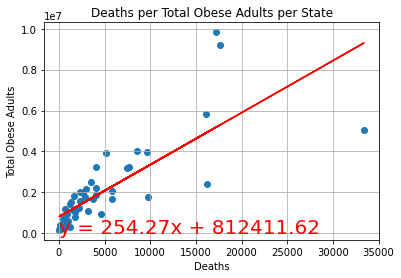

In [42]:
#x and y values
x_values = bye_wdc['Deaths']
y_values = bye_wdc['Total Obese Adults Per State']

# plt.figure(figsize=(5, 5))

#linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

#showing the equation on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,.8),fontsize=20,color="red")

#printing out the r squared value
print(f"The r-squared is: {rvalue**2}")

#labels and grid
plt.title("Deaths per Total Obese Adults per State")
plt.xlabel('Deaths')
plt.ylabel('Total Obese Adults')
plt.grid()

plt.show()

http://localhost:8889/view/PNG's/Deaths%20per%20Total%20Obese%20Adults%20per%20State.png

The r-squared is: 0.630303581811436


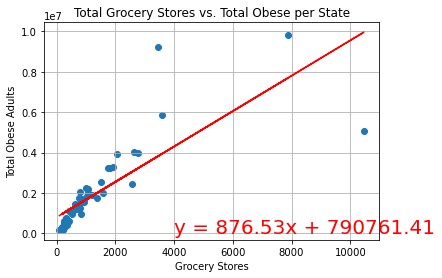

In [41]:
#x and y values
x_values = bye_wdc['Grocery Stores']
y_values = bye_wdc['Total Obese Adults Per State']

# plt.figure(figsize=(5, 5))

#linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

#showing the equation on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(4000,.02),fontsize=20,color="red")

#printing out the r squared value
print(f"The r-squared is: {rvalue**2}")

#labels and grid
plt.title("Total Grocery Stores vs. Total Obese per State")
plt.xlabel('Grocery Stores')
plt.ylabel('Total Obese Adults')
plt.grid()

plt.show()

The r-squared is: 0.9214006406047579


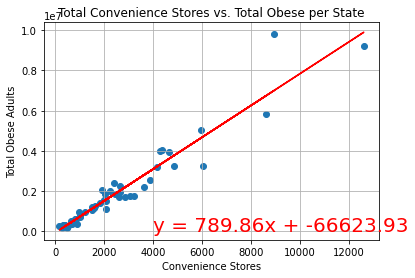

In [44]:
#x and y values
x_values = bye_wdc['Convenience Stores']
y_values = bye_wdc['Total Obese Adults Per State']

#linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

#showing the equation on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(4000,.02),fontsize=20,color="red")

#printing out the r squared value
print(f"The r-squared is: {rvalue**2}")

#labels and grid
plt.title("Total Convenience Stores vs. Total Obese per State")
plt.xlabel('Convenience Stores')
plt.ylabel('Total Obese Adults')
plt.grid()

plt.show()

The r-squared is: 0.8946112611635306


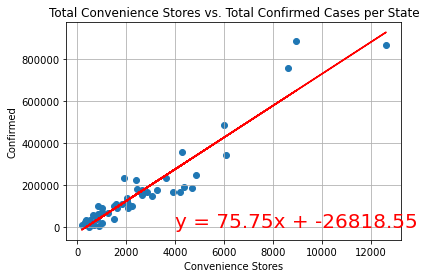

In [46]:
#x and y values
x_values = bye_wdc['Convenience Stores']
y_values = bye_wdc['Confirmed']

#linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

#showing the equation on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(4000,.02),fontsize=20,color="red")

#printing out the r squared value
print(f"The r-squared is: {rvalue**2}")

#labels and grid
plt.title("Total Convenience Stores vs. Total Confirmed Cases per State")
plt.xlabel('Convenience Stores')
plt.ylabel('Confirmed')
plt.grid()

plt.show()

At this point, I was shocked with how high the r-squared value is for the convenience stores vs. confirmed cases. I quickly realized that it might have to do not woth the correlation between the number of convenience stores in a state and how that in and of itself directly relates to the amount of confirmed cases, rather that it may be due to population density.

The number of cases in a state are higher depending on if the population is closer or farther apart. It also follows that the more people in an area, the more convenience stores there will be. As an anecdote, cities tend to have more convenience stores than do more rural areas.

This revelation led me to the thrid part of this project which aimed to turn the data into per capita to hopefully mitigate any influence population density or total population in general have on the final outcome.

## Part Three: Per Capita

In [53]:
renew_comb_condeaths_all_df = bye_wdc.drop(columns=["Total Population","Confirmed","Deaths","% Grocery Stores","% Convenience Stores","% of Obese Adults"])

# Create new columns to store per capita stats.
renew_comb_condeaths_all_df["# of Grocery Stores (Per Capita)"]=""
renew_comb_condeaths_all_df["# of Convenience Stores (Per Capita)"]=""
renew_comb_condeaths_all_df["Obese Adults (Per Capita)"]=""

# Order columns to show original(total) stats next to per capita stats for each state.
renew_comb_condeaths_all_df = renew_comb_condeaths_all_df[["Grocery Stores","# of Grocery Stores (Per Capita)","Convenience Stores","# of Convenience Stores (Per Capita)","Total Obese Adults Per State","Obese Adults (Per Capita)"]]
renew_comb_condeaths_all_df.head()

,Grocery Stores,# of Grocery Stores (Per Capita),Convenience Stores,# of Convenience Stores (Per Capita),Total Obese Adults Per State,Obese Adults (Per Capita)
state,,,,,,
Alabama,757.0,,3237.0,,1765878.840,
Alaska,215.0,,173.0,,251843.328,
Arizona,786.0,,1903.0,,2049272.075,
Arkansas,480.0,,1512.0,,1046734.850,
California,7874.0,,8949.0,,9826338.760,


In [54]:
# Access file one to begin per capita calculations.
pc_file_one_df = pd.DataFrame(file_one_df, columns= ['state','county_name','total_population','confirmed_per_100000', 'deaths_per_100000'])
pc_file_one_df.head()

,state,county_name,total_population,confirmed_per_100000,deaths_per_100000
0,Alabama,Autauga,55200.0,3661.23,54.35
1,Alabama,Baldwin,208107.0,3096.00,33.16
2,Alabama,Barbour,25782.0,3863.16,34.91
3,Alabama,Bibb,22527.0,3555.73,62.15
4,Alabama,Blount,57645.0,3249.20,43.37


In [55]:
# This DF shows confirmed cases per 100,000 people.
pc_confirmed = pc_file_one_df.groupby(["state"]).sum()["confirmed_per_100000"]
pc_confirmed_df = pd.DataFrame(pc_confirmed,columns=['confirmed_per_100000'])

pc_confirmed_df.head()

,confirmed_per_100000
state,
Alabama,260181.88
Alaska,30588.54
Arizona,51056.09
Arkansas,255135.29
California,103530.53


In [57]:
# This DF shows deaths per 100,000 people.
pc_deaths = pc_file_one_df.groupby(["state"]).sum()["deaths_per_100000"]
pc_deaths_df = pd.DataFrame(pc_deaths,columns=['deaths_per_100000'])

pc_deaths_df.head()

,deaths_per_100000
state,
Alabama,5209.30
Alaska,127.53
Arizona,1554.06
Arkansas,5138.08
California,1649.72


In [58]:
# Merge cases and deaths per capita 
comb_pc_df = pc_confirmed_df.join(pc_deaths_df,lsuffix="confirmed_per_100000")
comb_pc_df.head()

,confirmed_per_100000,deaths_per_100000
state,,
Alabama,260181.88,5209.30
Alaska,30588.54,127.53
Arizona,51056.09,1554.06
Arkansas,255135.29,5138.08
California,103530.53,1649.72


In [59]:
# Create seperate DF for total population
pc_totpop = pc_file_one_df.groupby(["state"]).sum()["total_population"]
pc_totpop_df = pd.DataFrame(pc_totpop,columns=['total_population'])
pc_totpop_df.head()

# Merge above DF with the new DF created for total population
comb_pctotpop_df = comb_pc_df.join(pc_totpop_df,lsuffix="deaths_per_100000")
comb_pctotpop_df.head()

,confirmed_per_100000,deaths_per_100000,total_population
state,,,
Alabama,260181.88,5209.30,4864680.0
Alaska,30588.54,127.53,736384.0
Arizona,51056.09,1554.06,6946685.0
Arkansas,255135.29,5138.08,2990671.0
California,103530.53,1649.72,39148760.0


In [62]:
# Create per capita DF for all variables 
comb_pc_all_df = comb_pctotpop_df.join(renew_comb_condeaths_all_df,lsuffix="total_population")
comb_pc_all_df["# of Grocery Stores (Per Capita)"]=(comb_pc_all_df["Grocery Stores"]/comb_pc_all_df["total_population"])*100000
comb_pc_all_df["# of Convenience Stores (Per Capita)"]=(comb_pc_all_df["Convenience Stores"]/comb_pc_all_df["total_population"])*100000
comb_pc_all_df["Obese Adults (Per Capita)"]=(comb_pc_all_df["Total Obese Adults Per State"]/comb_pc_all_df["total_population"])*100000

# Create a new DF with all per capita stats
comb_pc_all_df = comb_pc_all_df[['total_population','confirmed_per_100000','deaths_per_100000',"# of Grocery Stores (Per Capita)","# of Convenience Stores (Per Capita)","Obese Adults (Per Capita)"]]
comb_pc_all_df.head()

,total_population,confirmed_per_100000,deaths_per_100000,# of Grocery Stores (Per Capita),# of Convenience Stores (Per Capita),Obese Adults (Per Capita)
state,,,,,,
Alabama,4864680.0,260181.88,5209.30,15.561147,66.540862,36300.0
Alaska,736384.0,30588.54,127.53,29.196723,23.493177,34200.0
Arizona,6946685.0,51056.09,1554.06,11.314749,27.394361,29500.0
Arkansas,2990671.0,255135.29,5138.08,16.049910,50.557216,35000.0
California,39148760.0,103530.53,1649.72,20.113025,22.858962,25100.0


In [66]:
bye_pr_pc = comb_pc_all_df.drop(index='Puerto Rico')
bye_pr_pc.head()

,total_population,confirmed_per_100000,deaths_per_100000,# of Grocery Stores (Per Capita),# of Convenience Stores (Per Capita),Obese Adults (Per Capita)
state,,,,,,
Alabama,4864680.0,260181.88,5209.30,15.561147,66.540862,36300.0
Alaska,736384.0,30588.54,127.53,29.196723,23.493177,34200.0
Arizona,6946685.0,51056.09,1554.06,11.314749,27.394361,29500.0
Arkansas,2990671.0,255135.29,5138.08,16.049910,50.557216,35000.0
California,39148760.0,103530.53,1649.72,20.113025,22.858962,25100.0


In [69]:
bye_wdc_pc = bye_pr_pc.drop(index='District of Columbia')
bye_wdc_pc.head()

,total_population,confirmed_per_100000,deaths_per_100000,# of Grocery Stores (Per Capita),# of Convenience Stores (Per Capita),Obese Adults (Per Capita)
state,,,,,,
Alabama,4864680.0,260181.88,5209.30,15.561147,66.540862,36300.0
Alaska,736384.0,30588.54,127.53,29.196723,23.493177,34200.0
Arizona,6946685.0,51056.09,1554.06,11.314749,27.394361,29500.0
Arkansas,2990671.0,255135.29,5138.08,16.049910,50.557216,35000.0
California,39148760.0,103530.53,1649.72,20.113025,22.858962,25100.0


Part 4: Graphs for Per Capita

The r-squared is: 0.154207625230492


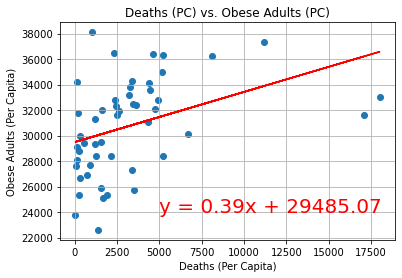

In [72]:
#x and y values
x_values = bye_wdc_pc['deaths_per_100000']
y_values = bye_wdc_pc['Obese Adults (Per Capita)']

#linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

#showing the equation on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5000,24000),fontsize=20,color="red")

#printing out the r squared value
print(f"The r-squared is: {rvalue**2}")

#labels and grid
plt.title("Deaths (PC) vs. Obese Adults (PC)")
plt.xlabel('Deaths (Per Capita)')
plt.ylabel('Obese Adults (Per Capita)')
plt.grid()

plt.show()

The r-squared is: 0.05862974267497212


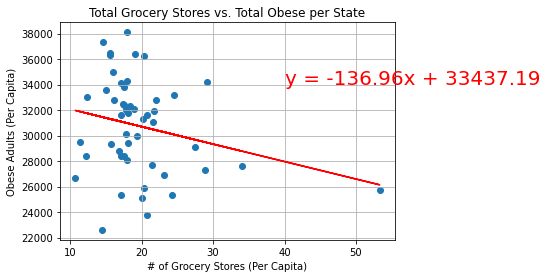

In [76]:
#x and y values
x_values = bye_wdc_pc['# of Grocery Stores (Per Capita)']
y_values = bye_wdc_pc['Obese Adults (Per Capita)']

#linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

#showing the equation on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(40,34000),fontsize=20,color="red")

#printing out the r squared value
print(f"The r-squared is: {rvalue**2}")

#labels and grid
plt.title("Total Grocery Stores vs. Total Obese per State")
plt.xlabel('# of Grocery Stores (Per Capita)')
plt.ylabel('Obese Adults (Per Capita)')
plt.grid()

plt.show()

The r-squared is: 0.22420922608477847


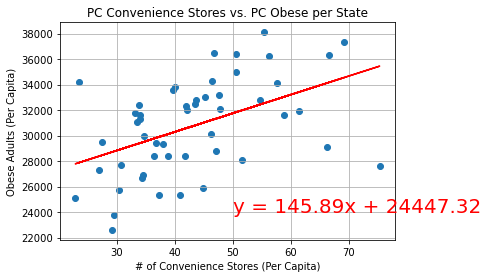

In [81]:
#x and y values
x_values = bye_wdc_pc['# of Convenience Stores (Per Capita)']
y_values = bye_wdc_pc['Obese Adults (Per Capita)']

#linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

#showing the equation on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(50,24000),fontsize=20,color="red")

#printing out the r squared value
print(f"The r-squared is: {rvalue**2}")

#labels and grid
plt.title("PC Convenience Stores vs. PC Obese per State")
plt.xlabel('# of Convenience Stores (Per Capita)')
plt.ylabel('Obese Adults (Per Capita)')
plt.grid()

plt.show()

The r-squared is: 0.14200591729380665


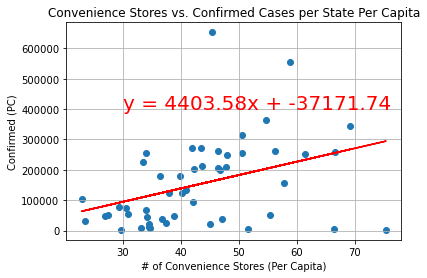

In [85]:
#x and y values
x_values = bye_wdc_pc['# of Convenience Stores (Per Capita)']
y_values = bye_wdc_pc['confirmed_per_100000']

#linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

#showing the equation on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,400000),fontsize=20,color="red")

#printing out the r squared value
print(f"The r-squared is: {rvalue**2}")

#labels and grid
plt.title("Convenience Stores vs. Confirmed Cases per State Per Capita")
plt.xlabel('# of Convenience Stores (Per Capita)')
plt.ylabel('Confirmed (PC)')
plt.grid()

plt.show()

Conclusion: Conclusion: Each variable tends to have a positive correlation to the confirmed cases and deaths across the USA. Science has confirmed (long before this project was completed) that health does impact a person's survivability while positive with COVID-19. 


cont.: COVID-19 has greatly impacted all parts of society. To think socioeconomic factors like the availability and frequency of convenience stores and grocery stores in a community has no impact on COVID-19 cases and deaths would be ignorant. While we must continue to stay safe and protect the most vulnerable, we should also consider shedding more light on health. The USA is one of the unhealthiest countries in the world which may be one reason as to why our case and death rate is so high. 

Thanks for taking the time to go through my first data analysis project! It was extremely fun to find real-world conclusions based off of data. Please see my [LinkedIn](https://www.linkedin.com/in/nicholas-faber42/) for more projects and experiences. If you have any suggestions as to how I should improve this repo, please feel free to email me at nfaber@sandiego.edu or send a DM on LinkedIn.